In [72]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
from scipy.stats import ttest_ind, probplot

In [73]:
file_path = 'diabetes.csv'
df = pd.read_csv(file_path)

display(df.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [74]:
# Replace 0's with NaN in columns where 0's are not possible
for col in df.columns:
    if col in ['Pregnancies', 'Outcome']:
        continue
    df[col] = df[col].replace(0, np.nan)

# Remove NaN rows in data
df_no_nan = df.dropna()

# Calculate the mean and standard deviation for each column
means = df_no_nan.mean()
stds = df_no_nan.std()

# Define threshold as 4 standard deviations from mean
std_threshold = 4

# Create boolean DataFrame indicating whether or not observations exceed threshold
conditions = (df_no_nan < (means - std_threshold * stds)) | (df_no_nan > (means + std_threshold * stds))

# Any row that should be removed will have at least one True in the conditions DataFrame
rows_to_remove = conditions.any(axis=1)

# Remove the rows that meet the condition
df_no_nan = df_no_nan[~rows_to_remove]




In [75]:
# Save as CSV for later use
df_no_nan.to_csv('diabetes_removed_nan.csv', index=False)

# Read the DataFrame from CSV file. This will be used from now on
new_df = pd.read_csv("diabetes_removed_nan.csv")

# Display DataFrame and print No. of observations
display(new_df.head())
len(new_df)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
1,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
2,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
3,5,166.0,72.0,19.0,175.0,25.8,0.587,51,1
4,0,118.0,84.0,47.0,230.0,45.8,0.551,31,1


383

In [76]:
# Which coloumns to drop when standardizing:
drop_coloumns = ['Outcome']#, 'DiabetesPedigreeFunction'

# Get all remaining columns in lists
features = [col for col in df.columns if col not in [kol for kol in drop_coloumns]]

# Standardize data
x = new_df.loc[:, features].values
x = StandardScaler().fit_transform(x)

# Save standardized DataFrame as CSV in case we want to use it later. Add the 'Outcome' column as well
new_x = pd.DataFrame(x, columns=features).assign(Outcome=new_df['Outcome'])
new_x.to_csv('diabetes_data_transformed.csv')

In [77]:
# Create DataFrame of summary statistics
data_details_df = pd.DataFrame({
    'Attribute' : features,
    'Min' : [min(new_df[features[i]]) for i in range(len(x.T))]    ,
    'Max' : [max(new_df[features[i]]) for i in range(len(x.T))]    ,
    'Mean' : [np.mean(new_df[features[i]]) for i in range(len(x.T))]    ,
    'Median' : [np.median(new_df[features[i]]) for i in range(len(x.T))]  ,
    'Variance' : [np.var(new_df[features[i]]) for i in range(len(x.T))]   ,
    'Q1' : [np.quantile(new_df[features[i]],0.25) for i in range(len(x.T))] ,
    'Q3' : [np.quantile(new_df[features[i]],0.75) for i in range(len(x.T))] 
})

# Print the LaTeX code for document
print(data_details_df.to_latex(index=False,float_format="%.2f"))


\begin{tabular}{lrrrrrrr}
\toprule
Attribute & Min & Max & Mean & Median & Variance & Q1 & Q3 \\
\midrule
Pregnancies & 0.00 & 15.00 & 3.29 & 2.00 & 9.82 & 1.00 & 5.00 \\
Glucose & 56.00 & 198.00 & 121.68 & 119.00 & 920.29 & 99.00 & 142.00 \\
BloodPressure & 24.00 & 110.00 & 70.56 & 70.00 & 151.12 & 62.00 & 78.00 \\
SkinThickness & 7.00 & 60.00 & 28.89 & 29.00 & 107.29 & 21.00 & 36.00 \\
Insulin & 15.00 & 600.00 & 151.31 & 125.00 & 11200.92 & 76.50 & 190.00 \\
BMI & 18.20 & 57.30 & 32.84 & 33.10 & 43.88 & 28.35 & 36.90 \\
DiabetesPedigreeFunction & 0.09 & 1.70 & 0.51 & 0.45 & 0.09 & 0.27 & 0.68 \\
Age & 21.00 & 63.00 & 30.68 & 27.00 & 96.47 & 23.00 & 36.00 \\
\bottomrule
\end{tabular}



In [79]:
# Create an instance of the PCA class
pca = PCA()

# Apply PCA to the attributes
principalComponents = pca.fit_transform(x)

In [81]:
# Create DataFrame of PC values for each observation
principalDf = pd.DataFrame(data = principalComponents
             , columns = [f'principal component {i+1}' for i in range(len(principalComponents.T))])

[0.32441904 0.18744801 0.1455539  0.1242297  0.09350127 0.05041682
 0.03999719 0.03443407]
0.657420946857065


8.020942408376964

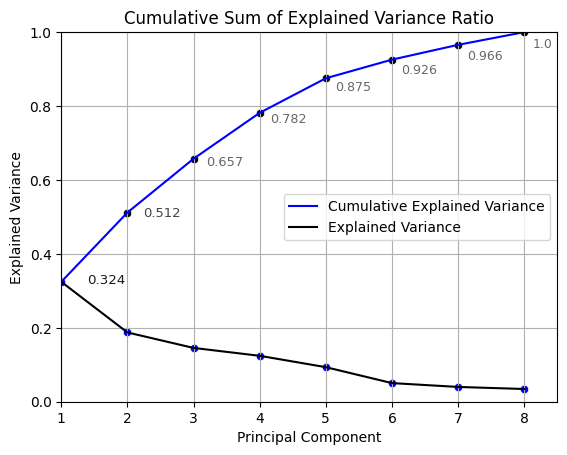

In [65]:
# Print the explained variance
print(pca.explained_variance_ratio_)

# Create the plot for cumulative sum of explained variance ratio
plt.figure()
plt.ylim(0,1)
plt.xlim(1,8.5)
plt.grid()
x_pc = [i+1 for i in range(len(principalComponents.T))]
sns.lineplot(x=x_pc, y=np.cumsum(pca.explained_variance_ratio_), color='blue', label='Cumulative Explained Variance')
sns.lineplot(x=x_pc, y=pca.explained_variance_ratio_, color='black', label='Explained Variance')
sns.scatterplot(x=x_pc, y=np.cumsum(pca.explained_variance_ratio_), color='black', marker='o')
sns.scatterplot(x=x_pc, y=pca.explained_variance_ratio_, color='blue', marker='o')
plt.title('Cumulative Sum of Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
for i, pc in enumerate(pca.explained_variance_ratio_[:]):
    val = sum(pca.explained_variance_ratio_[:i+1])
    plt.text(1+i+0.25/(val*2),val-0.03*(1.2*val)**2,round(val,3), alpha=max(0.6,1-val**2), size=10-val)

# Sum of explained variance of first 3 PCs    
print(sum(pca.explained_variance_ratio_[:3]))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
C:\Users\pvest\AppData\Local\Temp\ipykernel_25080\3411120677.py:9: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(principalDf.loc[indicesToKeep, 'principal component 1'],
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


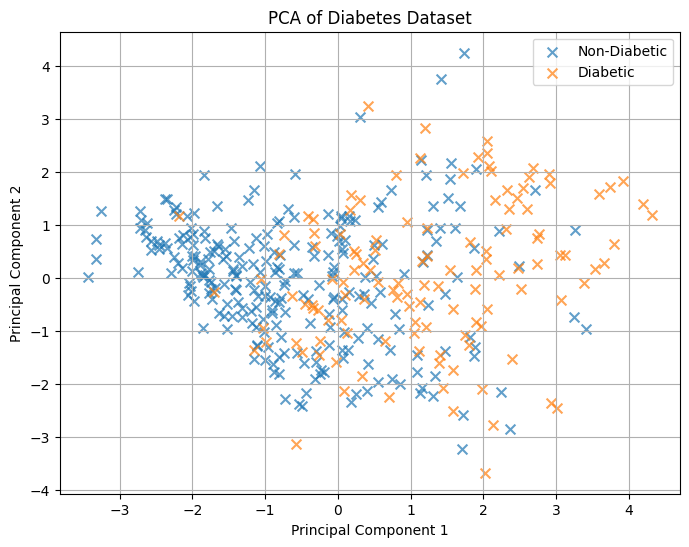

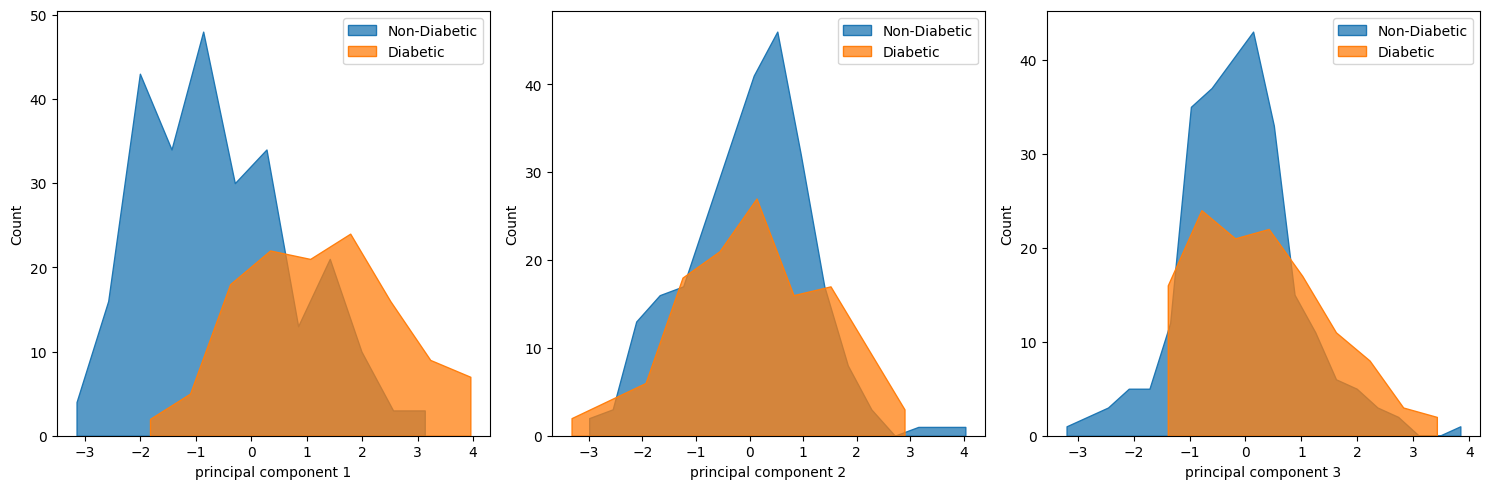

In [83]:
# Create scatterplot of observations projected onto first 2 PCs
# Color the markers based on outcome

plt.figure(figsize=(8, 6))

colors = sns.color_palette("tab10")
for outcome, color in zip([0, 1], colors):
    indicesToKeep = new_df['Outcome'] == outcome
    plt.scatter(principalDf.loc[indicesToKeep, 'principal component 1'],
                principalDf.loc[indicesToKeep, 'principal component 2'],
                c=color, edgecolor='k', alpha=0.7, s=50, marker='x',
                label=('Non-Diabetic' if outcome == 0 else 'Diabetic'))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Diabetes Dataset')
plt.grid(True)
plt.legend()
plt.show()


# Create density plots of the observations projected onto the first 3 PCs
plt.figure(figsize=(15, 5))

for i in range(min(len(principalComponents.T), 3)):
    plt.subplot(1, 3, i+1) 
    sns.histplot(principalDf.loc[new_df['Outcome'] == 0, f'principal component {i+1}'], color=colors[0], 
                label='Non-Diabetic', element='poly')
    sns.histplot(principalDf.loc[new_df['Outcome'] == 1, f'principal component {i+1}'], color=colors[1], 
                label='Diabetic', legend=True,element='poly')
    plt.legend()

plt.tight_layout()
plt.show()

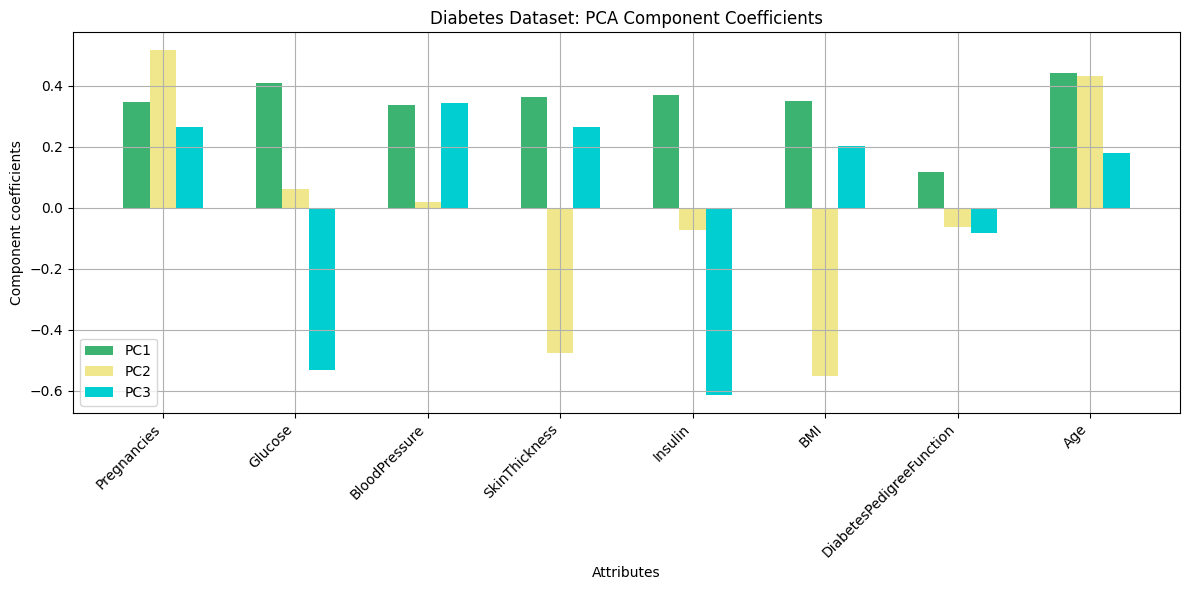

In [84]:
# Perform singular value decomposition
Y = x - np.ones((x.shape[0], 1)) * x.mean(0)
U, S, Vh = svd(Y, full_matrices=False)
V = Vh.T

# Get the coloumn names of explanatory attributes
new_new_df = new_df.drop([col for col in drop_coloumns], axis=1)
attributeNames = list(new_new_df.columns)

# Choose which PCs we would like to display coefficients for
pcs = [0, 1, 2]
legendStrs = ["PC" + str(e + 1) for e in pcs]
bw = 0.2
r = np.arange(1, len(attributeNames) + 1)

# Create plot of PC coefficients
colors = ["mediumseagreen", "khaki", "darkturquoise"]  
plt.figure(figsize=(12, 6))
for i in pcs:
    plt.bar(r + i * bw, V[:, i], width=bw, color=colors[i])
plt.xticks(r + bw, attributeNames, rotation=45, ha="right")
plt.xlabel("Attributes")
plt.ylabel("Component coefficients")
plt.legend(legendStrs)
plt.grid()
plt.title("Diabetes Dataset: PCA Component Coefficients")
plt.tight_layout()  
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Text(0, 0.5, 'PC2')

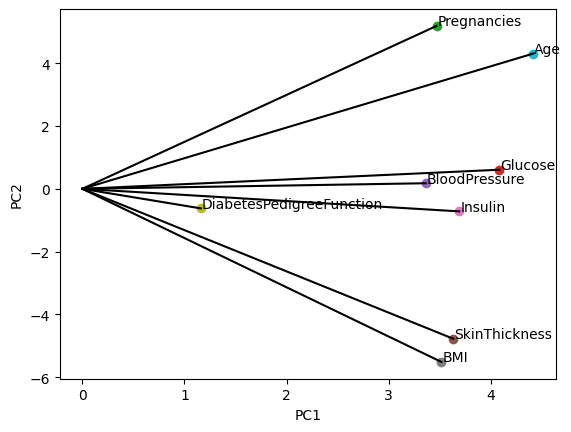

In [85]:
# Create plot explaining the effect of attributes on PC1 and PC2
plt.figure()
colors = sns.color_palette("tab10")[2:]

for i, att in enumerate(attributeNames):
    x = Vh[0,i]*10
    y = Vh[1,i]*10
    color = colors[i % len(colors)]
    plt.scatter(x, y, marker = 'o', c=color)

    plt.plot([0,x], [0, y], color="black")

    plt.text(x+0.01, y+0.01, att, fontsize=10)
plt.xlabel('PC1')
plt.ylabel('PC2')

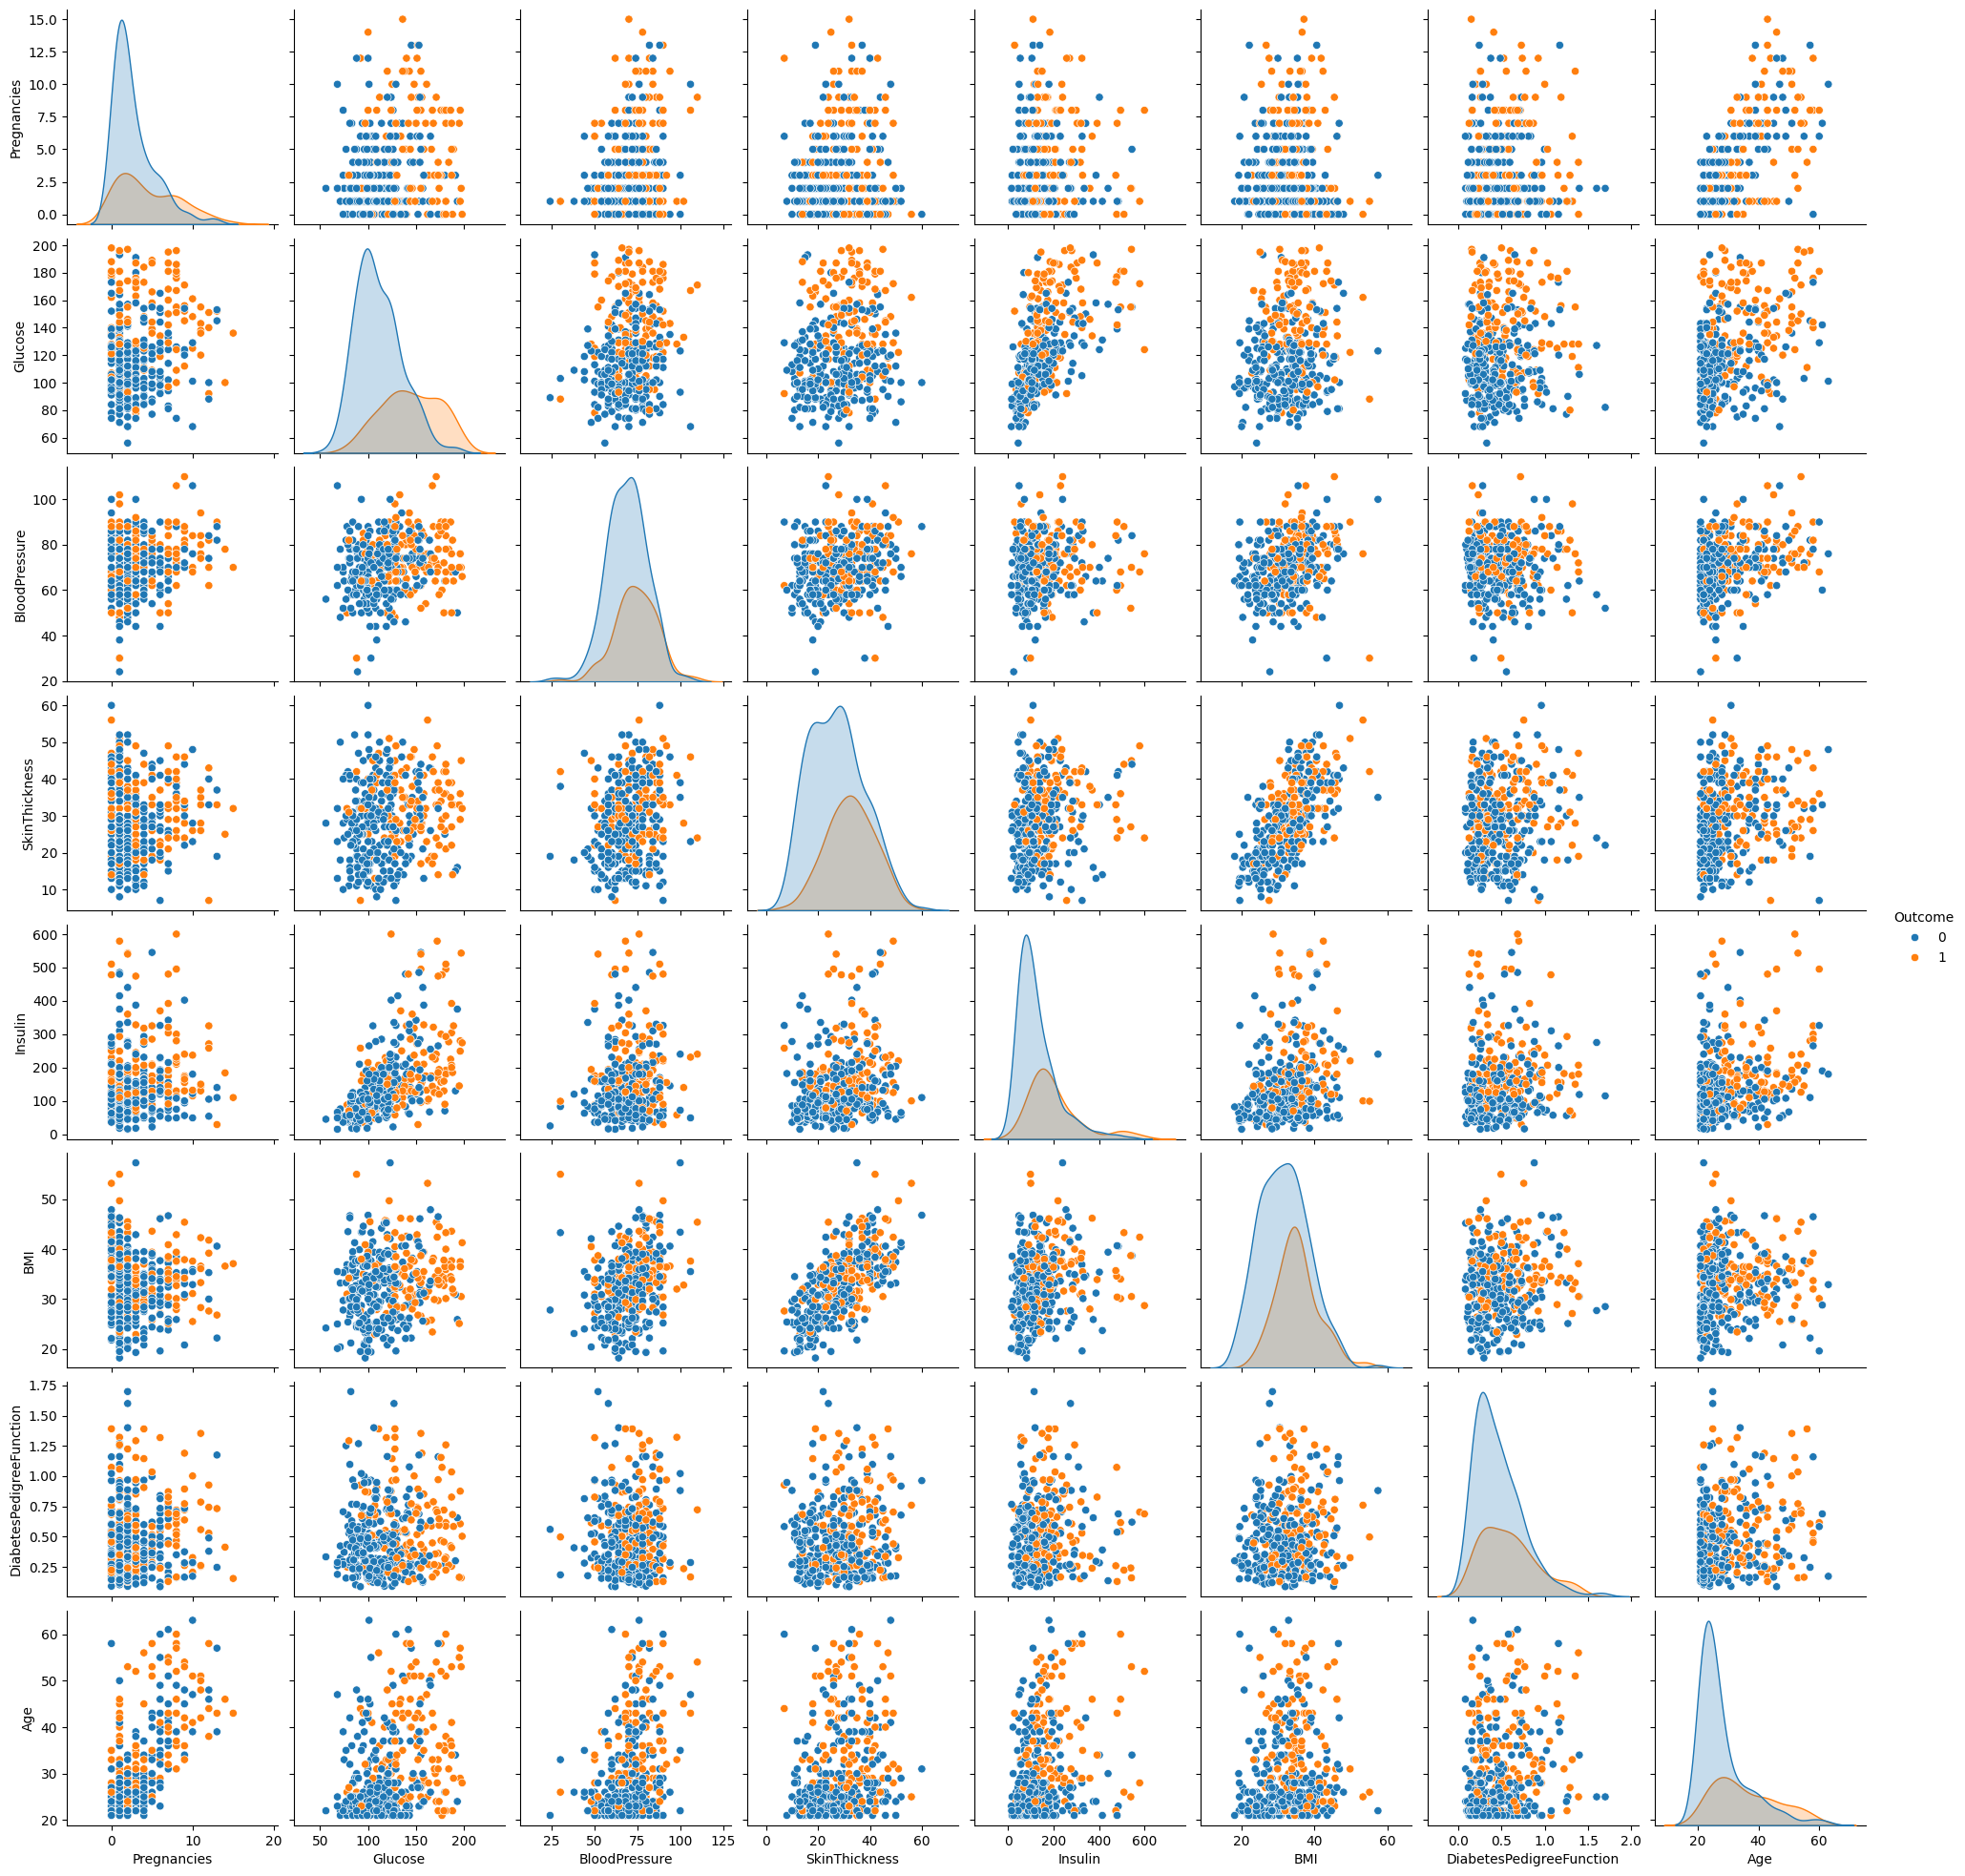

In [86]:
# Create scatterplots of attributes and color the markers based on outcome
sns.pairplot(new_df, hue='Outcome')

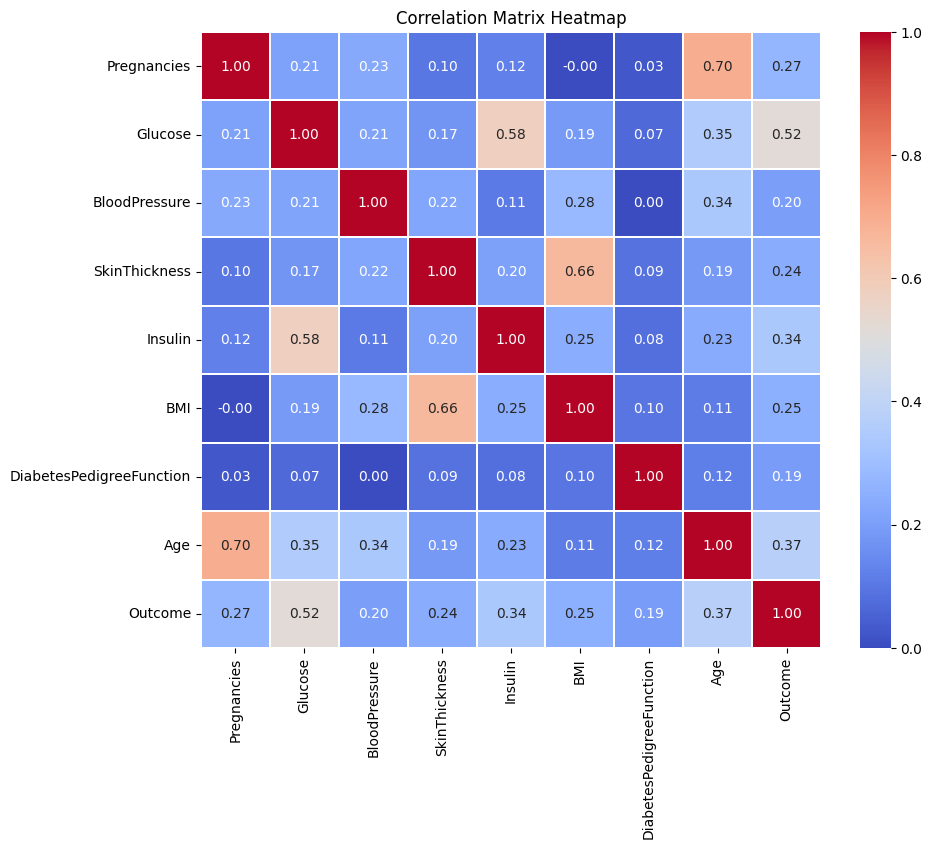

In [ ]:
# Calculate the correlation matrix
corr_matrix = new_df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.05)
plt.title('Correlation Matrix Heatmap')

plt.show()

c:\Users\pvest\anaconda3\envs\mldm\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
c:\Users\pvest\anaconda3\envs\mldm\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
c:\Users\pvest\anaconda3\envs\mldm\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
c:\Users\pvest\anaconda3\envs\mldm\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
c:\Users\pvest\anaconda3\envs\mldm\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_

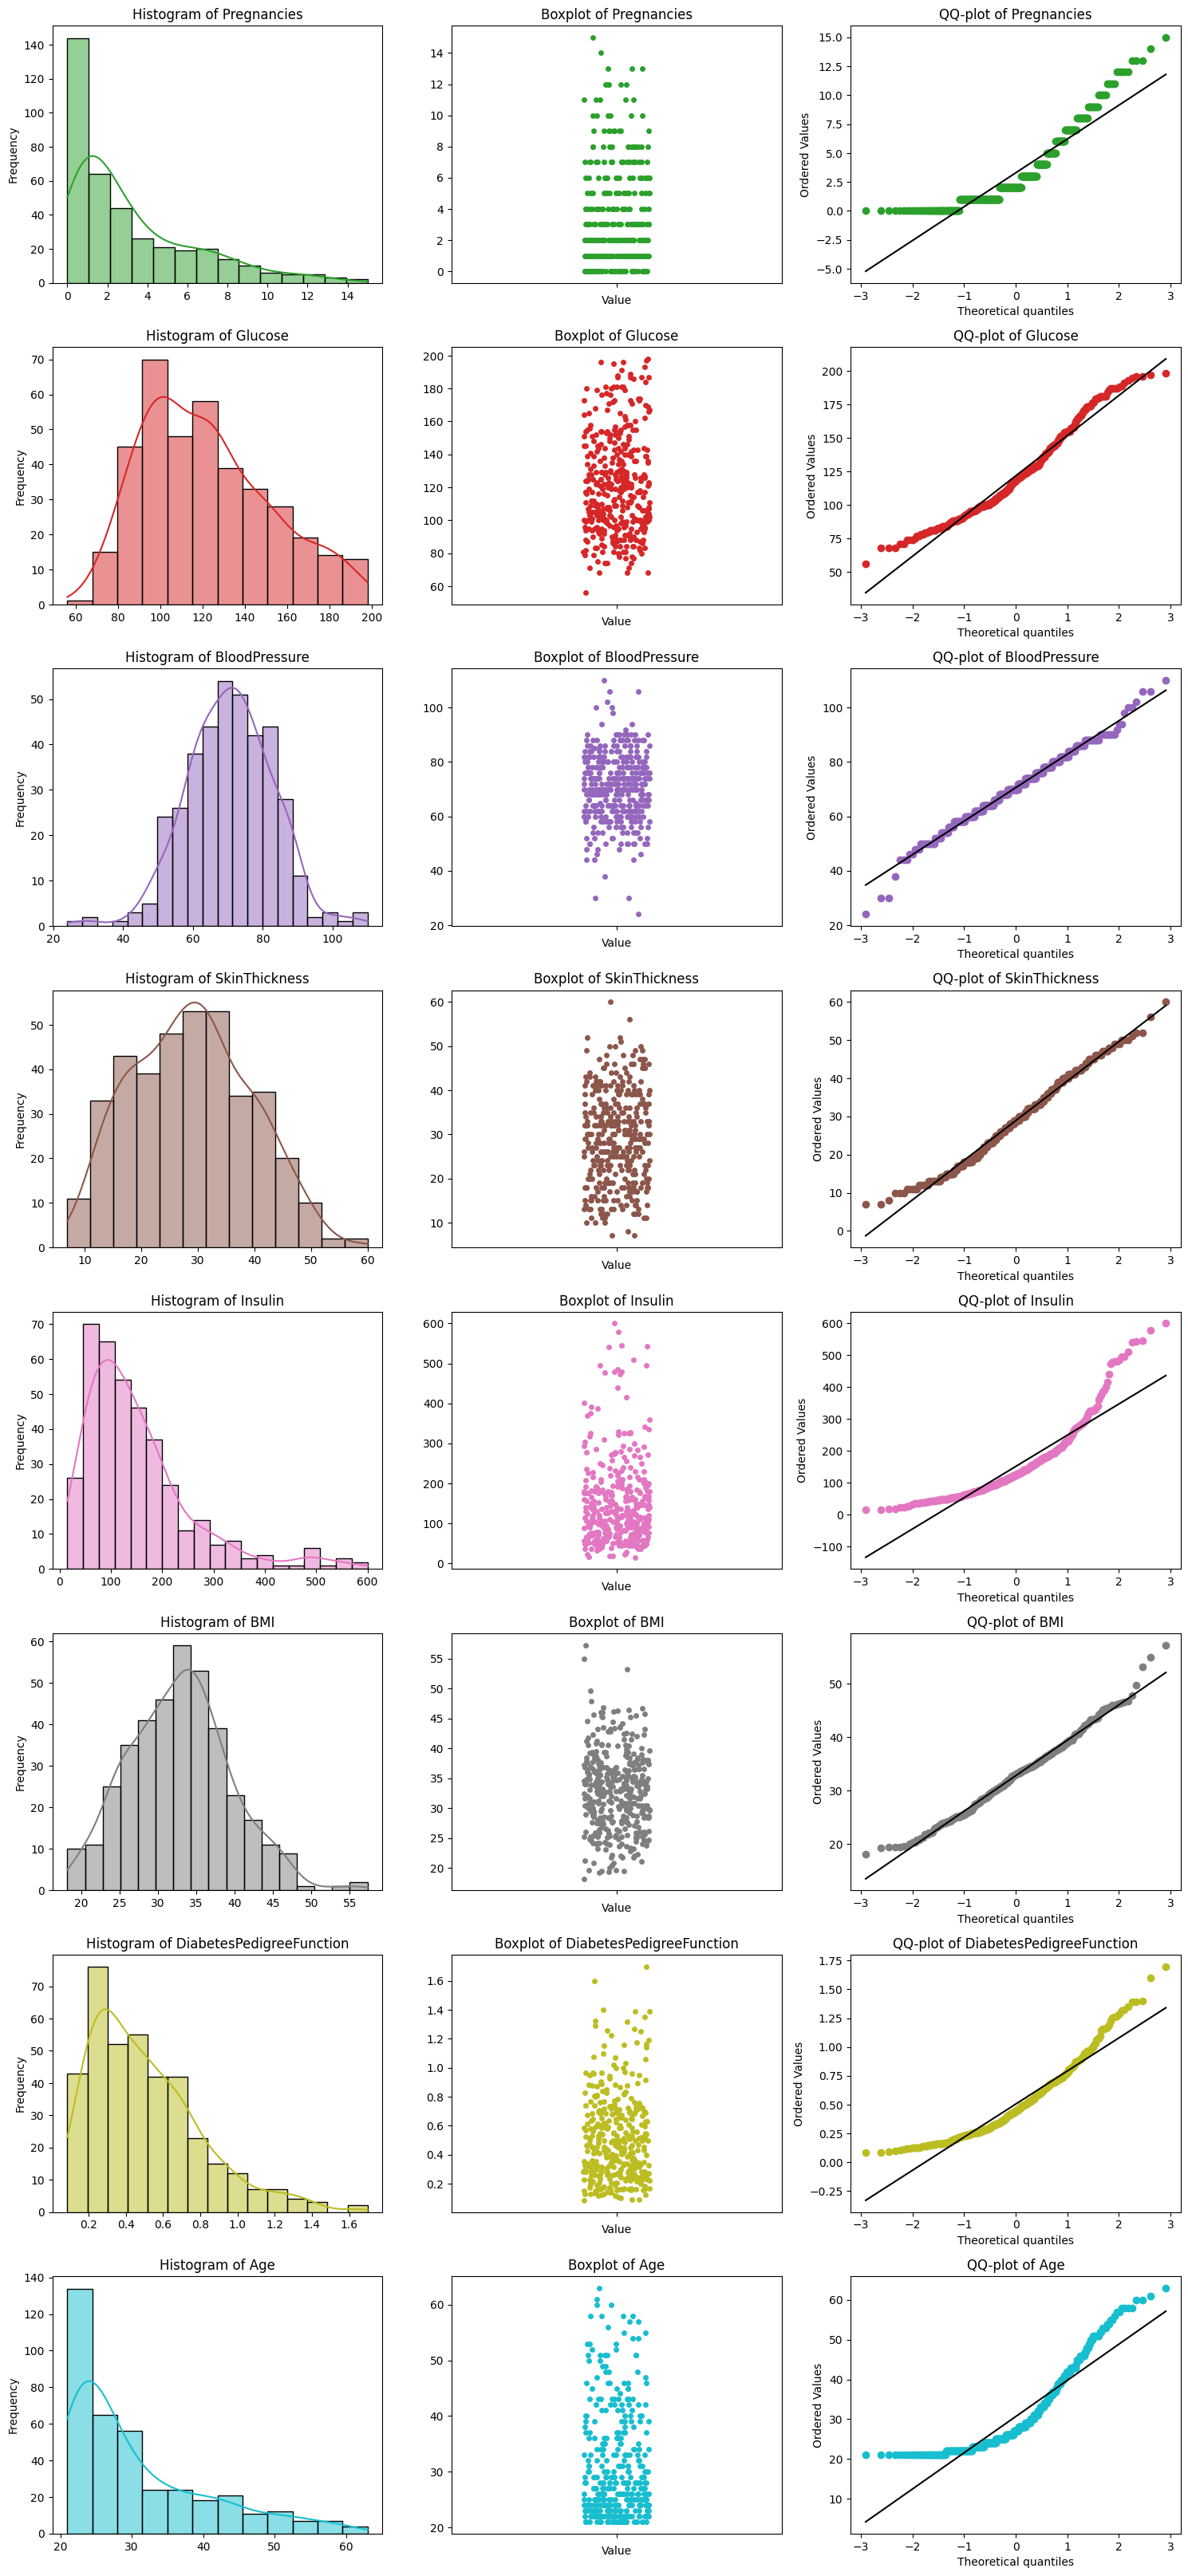

In [87]:
# Count the attributes
num_variables = len(new_df.columns) - 1

# Specify the dimensions of the plot
cols = 3 
rows = int(np.ceil(num_variables / cols)) * 3 

plt.figure(figsize=(5*cols, 4*rows))  

colors = sns.color_palette("tab10")[2:]

plot_index = 0

# Create plots for attributes
for i, column in enumerate(new_df.columns):

    # We do not want to plot the outcome
    if column == 'Outcome':
        continue

    color = colors[i % len(colors)]

    # Create histogram of current attribute
    ax_hist = plt.subplot(rows, cols, 3*plot_index + 1)  
    sns.histplot(new_df[column], kde=True, color=color, edgecolor='black', ax=ax_hist)
    ax_hist.set_title(f'Histogram of {column}')
    ax_hist.set_xlabel('')
    ax_hist.set_ylabel('Frequency')

    # Create boxplot of current attribute
    ax_box = plt.subplot(rows, cols, 3*plot_index + 2) 
    sns.stripplot(y=new_df[column], color=color, ax=ax_box, orient='h')
    ax_box.set_title(f'Boxplot of {column}')
    ax_box.set_xlabel('Value')
    ax_box.set_ylabel('')

    # Create QQ-plot of current attribute
    ax_qq = plt.subplot(rows, cols, 3*plot_index + 3)
    probplot(new_df[column], plot=ax_qq)
    ax_qq.get_children()[0].set_color(color)
    ax_qq.get_children()[1].set_color("black") 
    ax_qq.set_title(f'QQ-plot of {column}')

    plot_index += 1  # Increment plot index

plt.tight_layout() 
plt.show()